#Climate Change Sentiment Analysis


###Background
Many companies are built around lessening one’s environmental impact or carbon footprint. They offer products and services that are environmentally friendly and sustainable, in line with their values and ideals. They would like to determine how people perceive climate change and whether or not they believe it is a real threat.

### Problem Statement
Create a Machine Learning model that is able to classify whether or not a person believes in climate change, based on their novel tweet data.

# 1.Imported Libraries

In [77]:
#visualisation Libraries
import matplotlib.pyplot as plt
import seaborn as sns
#Analysis Libraries
import numpy as np
import pandas as pd
#NLP Libraries
import nltk
from nltk.corpus import stopwords
nltk.download(['punkt','stopwords'])
nltk.download('vader_lexicon')
nltk.download('popular')
from sklearn.utils import resample
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.tokenize import word_tokenize, TreebankWordTokenizer 
import re
import string
# ML Libraries
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC,SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
import spacy
nlp = spacy.load('en_core_web_sm')
from nltk import SnowballStemmer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[

# 2.Imported Data

In [78]:
df = pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
df.head(5)

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


df DataFrame contains three columns. sentiment, message and tweetid

In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15819 entries, 0 to 15818
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  15819 non-null  int64 
 1   message    15819 non-null  object
 2   tweetid    15819 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 370.9+ KB


#3.Data Inspection

Check unique values in each feature

In [80]:
number_of_unique=[df[i].nunique() for i in df.columns]
column_names=[i for i in df.columns]
unique_zip=list(zip(column_names,number_of_unique))
unique_df=pd.DataFrame(unique_zip,columns=['Column_Id','Unique_Values'])
unique_df

,Column_Id,Unique_Values
0,sentiment,4
1,message,14229
2,tweetid,15819


The message column has over 1000 duplicate entries that can be removed

Function 1 removes duplicate entries. First occurrence remains

In [81]:
#Function 1
#Delete duplicate

def delete_dup(df):
  df=df.copy()
  df = df.drop_duplicates(subset='message')
  return df

After running Function 1 runs 14229 unique columns remain

In [82]:
df=delete_dup(df)

In [83]:
number_of_unique=[df[i].nunique() for i in df.columns]
column_names=[i for i in df.columns]
unique_zip=list(zip(column_names,number_of_unique))
unique_df=pd.DataFrame(unique_zip,columns=['Columns_Feature','Unique_Values'])
unique_df

,Columns_Feature,Unique_Values
0,sentiment,4
1,message,14229
2,tweetid,14229


Check distribution of sentiment in data. Majority of data belongs to the Positive sentiment class, with Anti being the minority class

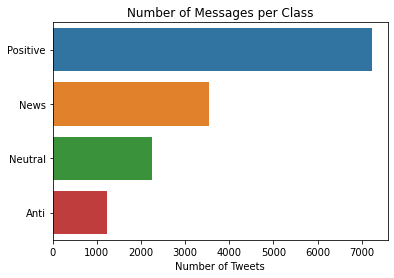

In [84]:
sentiment_count=list(df['sentiment'].value_counts())
sentiment_type=['Positive','News','Neutral','Anti']
sentiment_percentage=[round(i/sum(sentiment_count)*100,2) for i in sentiment_count]
sentiment=list(zip(sentiment_type,sentiment_count,sentiment_percentage))
sentiment_df=pd.DataFrame(sentiment,columns=['Class','Count','Percentage'])
sns.barplot(x=sentiment_count,y=sentiment_type)
plt.xlabel('Number of Tweets')
plt.title('Number of Messages per Class')
plt.show()

In [85]:
##############################

# 4.Data Preperation

Function 2 cleans the tweet messages by removing/editing unwanted information i.e URL's, lowercasing

In [86]:
#Function 2
def clean(text):

  text=text.replace("'",'')
  text=text.replace(".",' ')
  text=text.replace(",",' ')
  text=text.replace("_",' ')
  text=text.replace("!",' ')
  text=text.replace("RT",'relay') #Replace RT(Retweet) with relay
  text=text.replace(r'\d+','')
  text=re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(https?//[^\s]+))','url',text)
  text=text.lower()  # Lowercase tweet
  text =text.lstrip('\'"') # Remove extra white space
  
  return text

Function 3 removes punction at the beginning and end of words

In [87]:
#Function 3
def rm_punc(text):
  
  clean_text=[]
  for i in str(text).split():
    rm=i.strip('\'"?,.:_/<>!')
    clean_text.append(rm)
  return ' '.join(clean_text)

In [88]:
df['message']=df['message'].apply(clean)
df['message']=df['message'].apply(rm_punc)
df

,sentiment,message,tweetid
0,1,polyscimajor epa chief doesnt think carbon dio...,625221
1,1,its not like we lack evidence of anthropogenic...,126103
2,2,relay @rawstory researchers say we have three ...,698562
3,1,#todayinmaker# wired 2016 was a pivotal year ...,573736
4,1,relay @soynoviodetodas its 2016 and a racist s...,466954
...,...,...,...
15813,1,relay @thinkprogress epa head falsely claims c...,442853
15814,1,relay @ezlusztig they took down the material o...,22001
15816,0,notiven relay nytimesworld what does trump act...,384248
15817,-1,relay @sara8smiles hey liberals the climate ch...,819732


Function 4 replaces the @ with the word at
Function 5 removes all #

In [89]:
#Function 4
def at(text):
 
  #return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",text).split())
  return ' '.join(re.sub("(@+)","at ",text).split())

In [90]:
#Function 5
def hashtag(text):

  return ' '.join(re.sub("(#+)","",text).split())

In [91]:
#remove hashtags and @
df['message']=df['message'].apply(at)
df['message']=df['message'].apply(hashtag)

Cleaned tweet messages are now in a more appropriate form for classification

In [92]:
df.head(5)

,sentiment,message,tweetid
0,1,polyscimajor epa chief doesnt think carbon dio...,625221
1,1,its not like we lack evidence of anthropogenic...,126103
2,2,relay at rawstory researchers say we have thre...,698562
3,1,todayinmaker wired 2016 was a pivotal year in ...,573736
4,1,relay at soynoviodetodas its 2016 and a racist...,466954


#5.Tokenize and Lemmatization

Split tweets into individual words via tokenization in the tokens column

In [93]:
tokeniser = TreebankWordTokenizer()
df['tokens'] = df['message'].apply(tokeniser.tokenize)
df

,sentiment,message,tweetid,tokens
0,1,polyscimajor epa chief doesnt think carbon dio...,625221,"[polyscimajor, epa, chief, doesnt, think, carb..."
1,1,its not like we lack evidence of anthropogenic...,126103,"[its, not, like, we, lack, evidence, of, anthr..."
2,2,relay at rawstory researchers say we have thre...,698562,"[relay, at, rawstory, researchers, say, we, ha..."
3,1,todayinmaker wired 2016 was a pivotal year in ...,573736,"[todayinmaker, wired, 2016, was, a, pivotal, y..."
4,1,relay at soynoviodetodas its 2016 and a racist...,466954,"[relay, at, soynoviodetodas, its, 2016, and, a..."
...,...,...,...,...
15813,1,relay at thinkprogress epa head falsely claims...,442853,"[relay, at, thinkprogress, epa, head, falsely,..."
15814,1,relay at ezlusztig they took down the material...,22001,"[relay, at, ezlusztig, they, took, down, the, ..."
15816,0,notiven relay nytimesworld what does trump act...,384248,"[notiven, relay, nytimesworld, what, does, tru..."
15817,-1,relay at sara8smiles hey liberals the climate ...,819732,"[relay, at, sara8smiles, hey, liberals, the, c..."


Perform Lemmatization of tokens to group together the different inflected forms of a word so they can be analysed as a single item

Function 6 performs lemmatization on tweet tokens

In [94]:
#Function 6
def lemma(text):
  lemma = WordNetLemmatizer() 
  return [lemma.lemmatize(i) for i in text]


Generate Lemmatization column

In [95]:
df['lemma'] = df['tokens'].apply(lemma)
df.head(5)

,sentiment,message,tweetid,tokens,lemma
0,1,polyscimajor epa chief doesnt think carbon dio...,625221,"[polyscimajor, epa, chief, doesnt, think, carb...","[polyscimajor, epa, chief, doesnt, think, carb..."
1,1,its not like we lack evidence of anthropogenic...,126103,"[its, not, like, we, lack, evidence, of, anthr...","[it, not, like, we, lack, evidence, of, anthro..."
2,2,relay at rawstory researchers say we have thre...,698562,"[relay, at, rawstory, researchers, say, we, ha...","[relay, at, rawstory, researcher, say, we, hav..."
3,1,todayinmaker wired 2016 was a pivotal year in ...,573736,"[todayinmaker, wired, 2016, was, a, pivotal, y...","[todayinmaker, wired, 2016, wa, a, pivotal, ye..."
4,1,relay at soynoviodetodas its 2016 and a racist...,466954,"[relay, at, soynoviodetodas, its, 2016, and, a...","[relay, at, soynoviodetodas, it, 2016, and, a,..."


A new column clean message is generated from the lemma column

In [96]:
# Insert new clean message column
df['clean message'] = df['lemma'].apply(lambda i: ' '.join(i))
df.head(5)

,sentiment,message,tweetid,tokens,lemma,clean message
0,1,polyscimajor epa chief doesnt think carbon dio...,625221,"[polyscimajor, epa, chief, doesnt, think, carb...","[polyscimajor, epa, chief, doesnt, think, carb...",polyscimajor epa chief doesnt think carbon dio...
1,1,its not like we lack evidence of anthropogenic...,126103,"[its, not, like, we, lack, evidence, of, anthr...","[it, not, like, we, lack, evidence, of, anthro...",it not like we lack evidence of anthropogenic ...
2,2,relay at rawstory researchers say we have thre...,698562,"[relay, at, rawstory, researchers, say, we, ha...","[relay, at, rawstory, researcher, say, we, hav...",relay at rawstory researcher say we have three...
3,1,todayinmaker wired 2016 was a pivotal year in ...,573736,"[todayinmaker, wired, 2016, was, a, pivotal, y...","[todayinmaker, wired, 2016, wa, a, pivotal, ye...",todayinmaker wired 2016 wa a pivotal year in t...
4,1,relay at soynoviodetodas its 2016 and a racist...,466954,"[relay, at, soynoviodetodas, its, 2016, and, a...","[relay, at, soynoviodetodas, it, 2016, and, a,...",relay at soynoviodetodas it 2016 and a racist ...


#6.Rebalance data

Recap data distribution

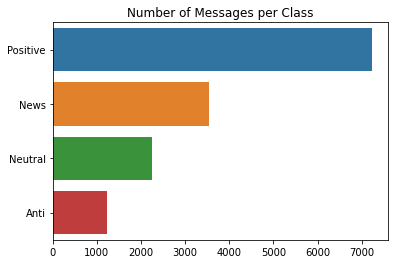

In [97]:
sns.barplot(x=sentiment_count,y=sentiment_type)
plt.title('Number of Messages per Class')
plt.show()

Data balance can be addressed through resampling, either up or down

In [98]:
news=df[df['sentiment']==2]
pos=df[df['sentiment']==1]
neutral=df[df['sentiment']==0]
anti=df[df['sentiment']==-1]
len(anti)

1221

In [99]:
# Downsample majority
#positive_downsampled = resample(pos,replace=False,n_samples=len(anti),random_state=27)
positive_downsampled = resample(pos,replace=False,n_samples=(len(anti)),random_state=27)
news_downsampled = resample(news,replace=False,n_samples=(len(anti)),random_state=27)
neutral_downsampled = resample(neutral,replace=False,n_samples=(len(anti)),random_state=27)
# Combine downsampled majority class with minority class
#downsampled = pd.concat([positive_downsampled, pos])
#len(downsampled)

In [100]:
# Upsample minority
#neutral_upsampled = resample(neutral,replace=True, n_samples=len(anti),random_state=27) 
#anti_upsampled = resample(anti,replace=True, n_samples=len(anti),random_state=27)
#news_upsampled = resample(anti,replace=True, n_samples=len(news),random_state=27)


# Combine upsampled minority class with majority class
#upsampled_neutral = pd.concat([neutral_upsampled, neutral])
#upsampled_anti = pd.concat([anti_upsampled, anti])
#upsampled_news = pd.concat([news_upsampled, news])

In [101]:
#x=[len(upsampled_neutral),len(news ),len(positive_downsampled),len(upsampled_anti)]
#y#=['neutral','news','positive','anti']

#sns.barplot(x,y)
#plt.title('Number of Messages per Class')
#plt.show()

In [102]:
#frames=[positive_downsampled,neutral_downsampled,anti,news_downsampled]
#df = pd.concat(frames)

In [103]:
len(df)

14229

#7.Model Training and Testing

Function 8 drops column features not needed

In [104]:
#Function 7
def drop(df,inputs):
  df=df.copy()
  df.drop(inputs,axis=1,inplace=True)
  return df

In [105]:
drop_list=['message','tweetid','tokens','lemma']
final_df=drop(df,drop_list)
final_df.head(5)

,sentiment,clean message
0,1,polyscimajor epa chief doesnt think carbon dio...
1,1,it not like we lack evidence of anthropogenic ...
2,2,relay at rawstory researcher say we have three...
3,1,todayinmaker wired 2016 wa a pivotal year in t...
4,1,relay at soynoviodetodas it 2016 and a racist ...


Train/Test Split

X and y training features split from final_df

In [106]:
y=df['sentiment']
X=df['clean message']

In [107]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

Parameter Search performed using GridSearch.(Takes a while to run, output hardcoded in pipeline.Uncheck to run)

In [108]:
#pipeline = Pipeline([('tfidf', TfidfVectorizer()),('clf', SVC())])
#pipeline = Pipeline([('tfidf', TfidfVectorizer(analyzer='word',max_features=5000)),('clf', LinearSVC())])

#parameters = {
 #   'tfidf__max_df': (0.25, 0.5, 0.75),'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
   # 'tfidf__max_features':(500,2500,5000),'clf__C':(0.1,1,10),'clf__gamma':(1,0.1,0.001)}

#grid_search = GridSearchCV(pipeline, parameters, cv=2, n_jobs=2, verbose=3)
#grid_search.fit(X_train, y_train)

In [109]:
#grid_search.best_params_

In [110]:
#Results of GridSearch
print('c=10','gamma=1','max_df=0.25','max_features=5000','ngram=(1,1)')

c=10 gamma=1 max_df=0.25 max_features=5000 ngram=(1,1)


In [111]:
#grid_predictions = grid_search.predict(X_test)

Fitting model with optimized parameters

In [112]:
svc = Pipeline([('tfidf', TfidfVectorizer(max_df=0.75,max_features=5000,ngram_range=(1,1))),('clf', SVC(C=10,gamma=1))])

#train model
model=svc.fit(X_train, y_train)

# Form a prediction set
predictions = model.predict(X_test)

In [113]:
print('Confusion Matrix')
print('')
print(confusion_matrix(y_test,predictions))
print('')
print('Classification Report')
print('')
print(classification_report(y_test,predictions))
print('')
print('The model accuracy is :',accuracy_score(y_test,predictions))

Confusion Matrix

[[ 115   40  146   10]
 [  31  182  309   38]
 [  16   80 1569  130]
 [   1    5  190  696]]

Classification Report

              precision    recall  f1-score   support

          -1       0.71      0.37      0.49       311
           0       0.59      0.33      0.42       560
           1       0.71      0.87      0.78      1795
           2       0.80      0.78      0.79       892

    accuracy                           0.72      3558
   macro avg       0.70      0.59      0.62      3558
weighted avg       0.71      0.72      0.70      3558


The model accuracy is : 0.7200674536256324


Save model as pickle

In [114]:
import pickle
model_save_path = "SVC.pkl"
with open(model_save_path,'wb') as file:
    pickle.dump(svc,file)

#8.Test

Perform data preparation (Section 3) on test dataframe

In [115]:
test['message']=test['message'].apply(clean) #clean data
test['message']=test['message'].apply(rm_punc) #remove punctuation
test['message']=test['message'].apply(at) #replace @
test['message']=test['message'].apply(hashtag) #remove #

In [116]:
#Tokenize messages
tokeniser = TreebankWordTokenizer()
test['tokens'] = test['message'].apply(tokeniser.tokenize)

In [117]:
#Lemmatize tokens column
test['lemma'] = test['tokens'].apply(lemma)

In [118]:
# Generate clean message column
test['clean message'] = test['lemma'].apply(lambda i: ' '.join(i))

In [119]:
#Drop columns not needed for predictions
drop_list=['message','tokens','lemma']
final_test=drop(test,drop_list)

Final Dataframe format for kaggle prediction

In [120]:
final_test

,tweetid,clean message
0,169760,europe will now be looking to china to make su...
1,35326,combine this with the polling of staffer re cl...
2,224985,the scary unimpeachable evidence that climate ...
3,476263,at karoli at morgfair at osborneink at dailyko...
4,872928,relay at fakewillmoore female orgasm cause glo...
...,...,...
10541,895714,relay at brittanybohrer brb writing a poem abo...
10542,875167,2016 the year climate change came home during ...
10543,78329,relay at loop vanuatu pacific country positive...
10544,867455,relay at xanria 00018 you ’ re so hot you must...


Load model pickle to make predictions

In [121]:
model_load_path = "SVC.pkl"
with open(model_load_path,'rb') as file:
    pickle_rick = pickle.load(file)

In [122]:
kaggle_predictions = pickle_rick.predict(final_test['clean message'])
kaggle_predictions = pd.DataFrame(kaggle_predictions)
kaggle_predictions.rename(columns={0: "sentiment"}, inplace=True)
kaggle_predictions["tweetid"] = test['tweetid']
cols = ['tweetid','sentiment']
kaggle_predictions = kaggle_predictions[cols]

Write predictions to upload_kaggle_pred.csv

In [123]:
kaggle_predictions.to_csv(path_or_buf='/content/upload_kaggle_pred.csv',index=False)